In [1]:
import pandas as pd

# Path to the JSON file
json_file_path = r"output_data.json"

# Read the JSON file into a DataFrame
df = pd.read_json(json_file_path, orient='records')


In [2]:
import re


def clean(text):
    # List of regex patterns to remove from the text
    phrases_to_remove = [
        # Generalized technical specification and department headers
        r'TECHNICAL SPECIFICATION(?: AND GENERAL POINTS)?(?: Department of [A-Za-z\s]+)?(?: ITEM NAME [A-Za-z\s]+)?',
        r'DEPARTMENT OF [A-Z\s]+(?: ENT)?(?: ALL INDIA INSTITUTE OF MEDICAL SCIENCES)?(?:,? [A-Z\s,]+)?',
        
        # Generalized location and document details
        r'ALL INDIA INSTITUTE OF MEDICAL SCIENCES,?(?: [A-Z\s,]+)?',
        r'NEW DELHI-\d, INDIA',
        # Generic patterns
        r'Sr\. No',             # Removes "Sr. No"
        r'Page \d+ of \d+',     # Removes "Page X of Y"
        r'T\.No\.\d+CNCNS\d+St', # Removes specific technical identifiers
        r'\b[A-Za-z]\.\s*',     # Removes single letter followed by a dot and space (e.g., "A. ", "B. ")
        r'\d{2}\s[a-z]',        # Removes numbers followed by a lowercase letter (e.g., "12 a")
        r'\d+\.',               # Removes numbered list items (e.g., "1.", "2.", etc.)
        r'01No\.02Nos',         # Removes specific unwanted phrases (e.g., "01No.02Nos")
        r'\d*',
    ]
        # Remove escape characters and unwanted whitespace
    text = text.encode('ascii', 'ignore').decode('ascii')  # Remove non-ASCII characters
    text = re.sub(r'\r\n|\r|\n', ' ', text)  # Normalize newlines to spaces
    # Apply all the patterns to the text
    for pattern in phrases_to_remove:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    return text.strip()




# Apply the clean function to the DataFrame column
df['technical_specification'] = df['technical_specification'].apply(clean)
pdfdf = df

In [3]:
import json

# Define the path to your JSON file
json_file_path = 'cyberesecurity disctioanry creation/keywords.json'  # Update this path if the file is in a different location

# Load the extracted keywords from the JSON file
with open(json_file_path, 'r') as json_file:
    extracted_keywords = json.load(json_file)

# Replace the security_keywords array with the keywords from the JSON file
security_keywords = extracted_keywords

# Print the updated array
print(f"Updated security_keywords array: {security_keywords}")


Updated security_keywords array: ['access control', 'anti-virus (anti-malware)', 'antivirus software', 'APT (Advanced Persistent Threat)', 'asset', 'authentication', 'authorization', 'backing up', 'BCP (Business Continuity Planning)', 'behavior monitoring', 'blacklist', 'block cipher', 'botnet', 'bug', 'BYOD (Bring Your Own Device)', 'ciphertext', 'clickjacking', 'cloud computing', 'CND (Computer Network Defense)', 'cracker', 'critical infrastructure', 'CVE (Common Vulnerabilities and Exposures)', 'cryptography', 'cyberattack', 'cyber ecosystem', 'cyberespionage', 'cybersecurity', 'cyber teams', 'data breach', 'data integrity', 'data mining', 'data theft', 'DDoS (Distributed Denial of Service) Attack', 'decrypt', 'digital certificate', 'digital forensics', 'DLP (Data Loss Prevention)', 'DMZ (Demilitarized Zone)', 'DOS (Denial of Service)', 'drive-by download', 'eavesdropping', 'encode', 'encryption key', 'firewall', 'hacker', 'hacktivism', 'honeypot', 'IaaS (Infrastructure-as-a-Service

In [4]:
import spacy
import pandas as pd

# Load the spaCy model
nlp = spacy.load("en_core_web_md")

# Tokenize using spaCy
def tokenize_text(text):
    return nlp(text)


# Function to filter sentences containing security-related keywords
# def filter_security_sentences(doc):
#     security_sentences = []
#     for sent in doc.sents:
#         if any(keyword in sent.text.lower() for keyword in security_keywords):
#             security_sentences.append(sent.text)
#     return ' '.join(security_sentences)

def filter_security_sentences(doc):
    security_sentences = []
    
    # Collect sentences with security-related keywords
    for sent in doc.sents:
        # Tokenize the sentence into words and check lemmas for partial matches
        lemmas_in_sentence = [token.lemma_ for token in sent]
        if any(keyword in ' '.join(lemmas_in_sentence) for keyword in security_keywords):
            security_sentences.append(sent.text)
    # Return the filtered text without stopwords
    return ' '.join(security_sentences)


# Function to count sentences
def count_sentences(doc):
    return len(list(doc.sents))

# Function to count security-related sentences
def count_security_sentences(doc):
    return sum(1 for sent in doc.sents if any(keyword in sent.text.lower() for keyword in security_keywords))



# Tokenize each cell in the 'technical_specification' column
df['tokenized_specification'] = df['technical_specification'].apply(tokenize_text)

# Apply the filter function to get security-related sentences
df['security_related_sentences'] = df['tokenized_specification'].apply(filter_security_sentences)

# Apply the count functions
df['sentence_count'] = df['tokenized_specification'].apply(count_sentences)
df['security_sentence_count'] = df['tokenized_specification'].apply(count_security_sentences)

# Display the DataFrame
print(df[['technical_specification', 'security_related_sentences', 'sentence_count', 'security_sentence_count']])




                               technical_specification  \
0    --- Page  --- Tender for Fundus Fluorescein an...   
1    --- Page  --- Tender for Auto Transfusion Mach...   
2    --- Page  ---                                 ...   
3    --- Page  ---     GTE No.: AIIMS/ R/CS/URO///G...   
4    --- Page  ---                                 ...   
..                                                 ...   
755  --- Page  ---                                 ...   
756  --- Page  ---     Tender No. AIIMS/R/CS/OBGY//...   
757  --- Page  ---                                 ...   
758  --- Page  ---       SECTION  VII  TECHNICAL  S...   
759  --- Page  ---                                 ...   

                            security_related_sentences  sentence_count  \
0                                                                    9   
1                                                                   39   
2    Integrated facility for antivirus with free ti...             333   
3      

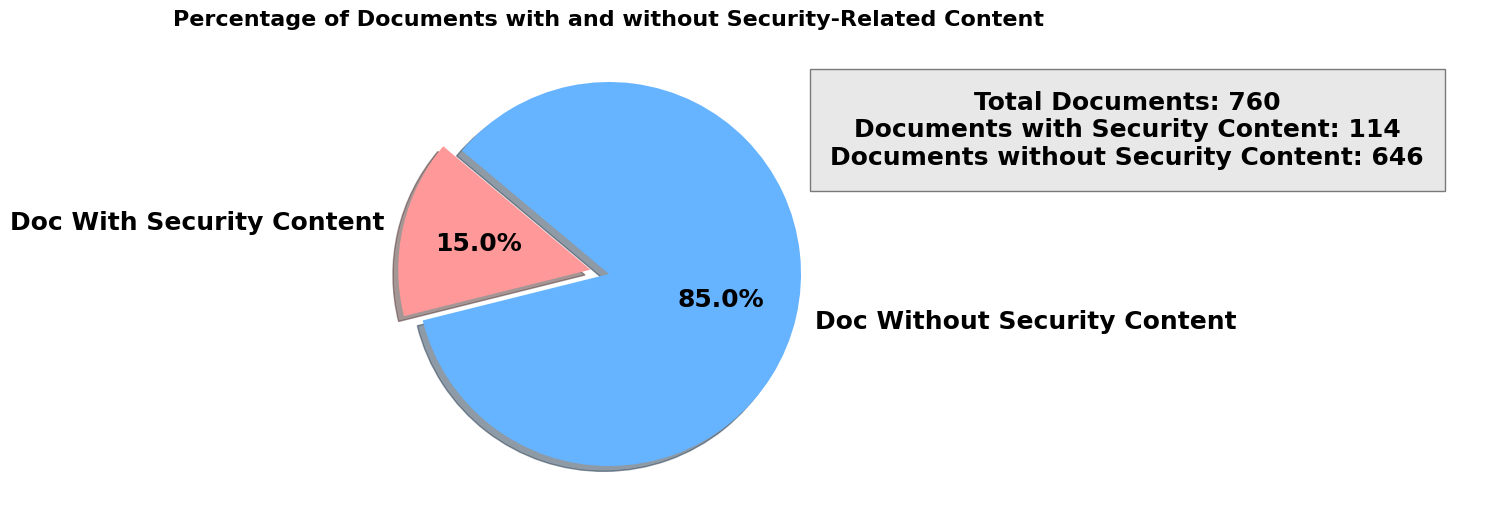

In [12]:
import matplotlib.pyplot as plt
import pandas as pd



# Calculate non-security related sentences
df['non_security_sentence_count'] = df['sentence_count'] - df['security_sentence_count']

# Calculate the number of documents with and without security-related content
num_documents_with_security = (df['security_sentence_count'] > 0).sum()
num_documents_without_security = (df['security_sentence_count'] == 0).sum()

# Prepare data for the pie chart
labels = ['Doc With Security Content', 'Doc Without Security Content']
sizes = [num_documents_with_security, num_documents_without_security]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # only "explode" the 1st slice (i.e. 'With Security Content')

# Plot pie chart and custom legend
plt.figure(figsize=(12, 6))

# Create pie chart
plt.subplot(1, 2, 1)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140,textprops={'fontsize': 18, 'fontweight': 'bold', 'color': 'black'})
plt.title('Percentage of Documents with and without Security-Related Content', 
          fontsize=16, fontweight='bold', ha='center')

# Create a custom legend with additional information
plt.subplot(1, 2, 2)
plt.axis('off')  # Hide axes

# Add legend text
legend_text = (
    f"Total Documents: {len(df)}\n"
    f"Documents with Security Content: {num_documents_with_security}\n"
    f"Documents without Security Content: {num_documents_without_security}"
)

# Use plt.text for precise control over text placement
plt.text(0.3, 0.8, legend_text, ha='center', va='center', fontsize=18,
         fontweight='bold', bbox={'facecolor': 'lightgrey', 'alpha': 0.5, 'pad': 15})

# Adjust layout to minimize whitespace
plt.subplots_adjust(left=0.0, right=0.95, top=0.95, bottom=0.15)

plt.show()



In [6]:
# import pandas as pd
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# import spacy
# from spacy.lang.en.stop_words import STOP_WORDS
# from spacy.tokens import Doc, Span, Token



# def preprocess_text(text):
#     # Create a spaCy Doc object
#     doc = nlp(text)
    
#     # Lemmatize and remove stop words
#     processed_tokens = [token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS and not token.is_punct and len(token.text)>1]
    
#     return ' '.join(processed_tokens)

# # Combine all security-related sentences into one text
# combined_text = ' '.join(df['security_related_sentences'].dropna())

# # Preprocess the combined text
# processed_text = preprocess_text(combined_text)

# # Generate the word cloud
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(processed_text)

# # Plot the word cloud
# plt.figure(figsize=(12, 6))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title('Word Cloud of Security-related Sentences')
# plt.show()


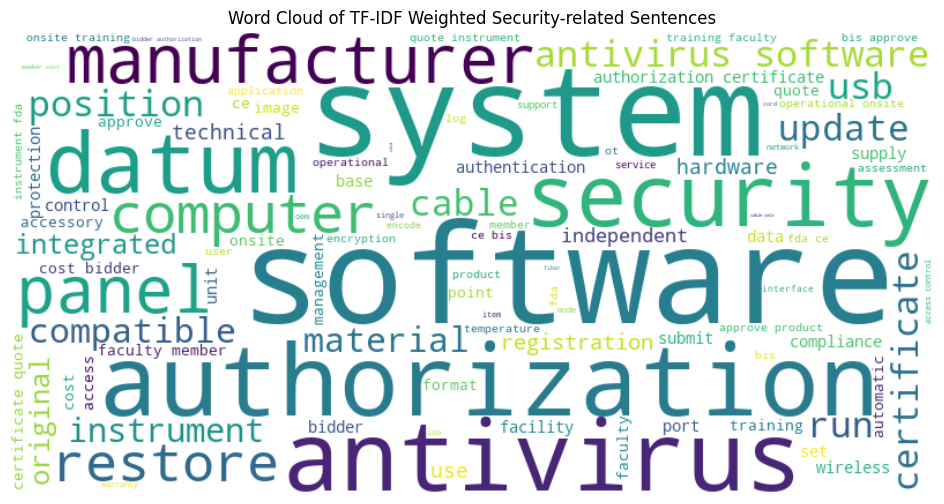

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Add more custom stopwords
additional_stopwords = {'device', 'feature', 'patch', 'upgrade','minimum','provide','late','report','follow','light','time','plate','page','aiims','include' ,'improvement','shall','year','free','possible','cassette','pre','tender','offer'}

# Update spaCy stopwords
custom_stopwords = STOP_WORDS.union(additional_stopwords)

# Preprocessing function with custom stopwords
def preprocess_text(text):
    # Create a spaCy Doc object
    doc = nlp(text)
    
    # Lemmatize and remove stop words, handling stopwords in a case-insensitive way
    processed_tokens = [
        token.lemma_.lower() for token in doc 
        if token.lemma_.lower() not in custom_stopwords 
        and not token.is_punct and len(token.text) > 1
    ]
    
    return ' '.join(processed_tokens)

# Combine and preprocess security-related sentences
combined_text = df['security_related_sentences'].dropna().apply(preprocess_text)

# Perform TF-IDF transformation
tfidf_vectorizer = TfidfVectorizer(max_features=100,ngram_range=(0,2))  # Limit the features for better visualization
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_text)

# Convert TF-IDF result to a dictionary of words and their weights
tfidf_scores = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1))

# Generate word cloud using TF-IDF scores
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of TF-IDF Weighted Security-related Sentences')
plt.show()


In [8]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Increase max features to allow more vocabulary
tfidf_vectorizer = TfidfVectorizer(max_features=100, ngram_range=(1, 2))  # Increased max features
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_text)

# Experiment with more topics
num_topics = 10  # Increased number of topics

# Perform NMF with options
nmf_model = NMF(n_components=num_topics, init='nndsvd', random_state=42, max_iter=200)
nmf_matrix = nmf_model.fit_transform(tfidf_matrix)

# Get the feature names (words) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Set to keep track of already used words
used_words = set()

# Display the top words for each topic without duplicates across all topics
for topic_idx, topic in enumerate(nmf_model.components_):
    top_features_indices = topic.argsort()[:-11:-1]  # Get the indices of the top 10 features
    top_features = [feature_names[i] for i in top_features_indices if feature_names[i] not in used_words]  # Filter out already used words
    
    # Add the newly selected words to the used set
    used_words.update(top_features)

    # Print only if there are unique features to display
    if top_features:
        print(f"Topic #{topic_idx + 1}: {', '.join(top_features)}")


Topic #1: security, software, run, independent, integrated, protection, system, image, base, ot
Topic #2: technical, certificate, instrument, authorization certificate, approve, submit, bidder, quote, certificate quote, onsite training
Topic #3: antivirus, computer, update, compatible, antivirus software, original, hardware, unit, facility
Topic #4: panel, cable, material, position, wireless, port, iso
Topic #5: datum, usb, restore, data, case
Topic #6: registration, point, encryption, authentication
Topic #7: authorization, manufacturer, use, warranty, compliance
Topic #8: control, access, user, patient
Topic #9: assessment, management, supply, accessory, temperature
Topic #10: set, service, application, item


In [10]:
df.to_html('check.html')